In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers, optimizers, metrics
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
import io
from zipfile import ZipFile

In [ ]:
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
r = requests.get(url)
z = ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('./ml-100k/u.data', '\t', names=names)
num_users = len(data.user_id.unique())
num_items = len(data.item_id.unique())

data = data.sample(frac=1)
train_indices = int(0.9 * data.shape[0])

train_data = data[:train_indices]
test_data = data[train_indices:]

x_train, y_train, x_test, y_test = (
    train_data[['user_id', 'item_id']].values - 1,
    train_data['rating'].values,
    test_data[['user_id', 'item_id']].values - 1,
    test_data['rating'].values
)

In [ ]:
class MatrixFactorization(Model):
  def __init__(self, embedding_dim, num_users, num_items):
    super().__init__()
    self.user_embedding = layers.Embedding(num_users, embedding_dim,
                                           embeddings_regularizer=regularizers.l2(1e-4))
    
    self.item_embedding = layers.Embedding(num_items, embedding_dim,
                                           embeddings_regularizer=regularizers.l2(1e-4))
    
    self.user_bias = layers.Embedding(num_users, 1)
    self.item_bias = layers.Embedding(num_items, 1)

    self.dot = layers.Dot(1)

  def call(self, inputs):
    user_row = self.user_embedding(inputs[:, 0])
    item_row = self.item_embedding(inputs[:, 1])
    user_bias = self.user_bias(inputs[:, 0])
    item_bias = self.item_bias(inputs[:, 1])
    outputs = self.dot([user_row, item_row]) + user_bias + item_bias
    outputs = tf.nn.sigmoid(outputs)
    outputs = outputs * 4 + 1
    return outputs

model = MatrixFactorization(32, num_users, num_items)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
704/704 [==============================] - 3s 3ms/step - loss: 1.3427 - root_mean_squared_error: 1.1558 - val_loss: 1.1105 - val_root_mean_squared_error: 1.0419
Epoch 2/10
704/704 [==============================] - 2s 2ms/step - loss: 1.0179 - root_mean_squared_error: 0.9844 - val_loss: 0.9919 - val_root_mean_squared_error: 0.9638
Epoch 3/10
704/704 [==============================] - 2s 2ms/step - loss: 0.9484 - root_mean_squared_error: 0.9367 - val_loss: 0.9580 - val_root_mean_squared_error: 0.9396
Epoch 4/10
704/704 [==============================] - 2s 2ms/step - loss: 0.9129 - root_mean_squared_error: 0.9128 - val_loss: 0.9396 - val_root_mean_squared_error: 0.9258
Epoch 5/10
704/704 [==============================] - 2s 2ms/step - loss: 0.8900 - root_mean_squared_error: 0.8971 - val_loss: 0.9288 - val_root_mean_squared_error: 0.9182
Epoch 6/10
704/704 [==============================] - 2s 2ms/step - loss: 0.8722 - root_mean_squared_error: 0.8857 - val_loss: 0.9214 - val_

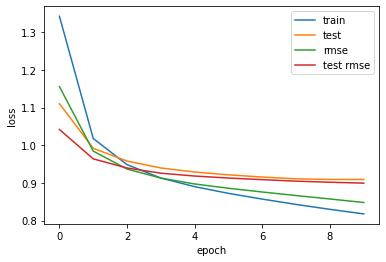

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test", "rmse", "test rmse"], loc="upper right")
plt.show()